# An example for euclidian reconstruction when intrinsic camera is unknown

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmosZhu/Dizhong_PythonUtils/blob/main/Notebooks/MultipleView_Geometry/auto_calibration.ipynb)

To start this notebook, you might need to understand how structure from motion works.

This notebook includes following keypoints:
- Projective reconstruction using PnP.
- Estimate the Absolute Dual Quadric.
- Decompose the Absolute Dual Quadric to euclidian transformation.
- Estimate the intrinsic camera from Absolute Dual Quadric.

### The ambiguity from projective reconstruction to euclidian reconstruction

When the intrinsic parameters is unknown, we can always get a pair of 3D point cloud $X$ and corresponding projection matrix $P$. Which satisfy the image projection equation $x=P\cdot X$. **This reconstruction is only a projective reconstruction**. Because it's also true when $x=P\cdot H \cdot H^{-1} X$. In order to get metric reconstruction, the general approach will be.
- Obtain a projective reconstruction {$P$, $X$}.
- Determine a rectifying homography $H$ from auto-calibration constraints, and transform to a metric reconstruction {$P\cdot H$, $H^{-1}\cdot X$}.

All the detail can be found in multiple-view geometry book (Second edition). Chapter 19.

### 0. Import path and load packages

In [20]:
import sys

sys.path.insert(0, '../../')

import cv2
import numpy as np
import torch
from GeoUtils_pytorch.Geo3D import (
    Epipolar,
    PnP,
    reconstruction
)
from GeoUtils_pytorch.common import (
    make_homegenous
)

from GeoUtils_pytorch.Cameras.PerspectiveCamera import (
    PerspectiveCamera,
    backProjection
)
from GeoUtils_pytorch.Geo3D import bundlAdjustment as BA
import open3d as o3d
from utils.plots import (
    plot_landmarks,
    plot_imageset,
)
from utils.plotly_helper import (
    plotly_pointcloud_and_camera
)

device = 'cpu'

### 1. Load images and do projective reconstruction
Load **Temple Ring** image sets and display.

There are 4 images in total


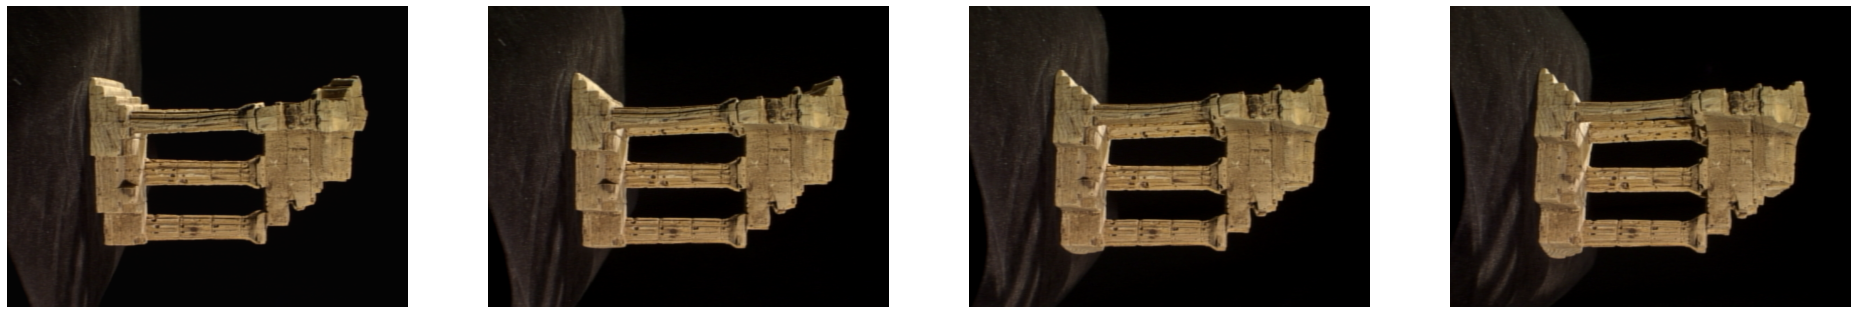

In [21]:
from test_datas.templeRing import datahelper

noofImages = 4
images, (Ks, Rs, ts) = datahelper.load_data(noofImages)

noofImages = images.shape[0]
h, w = images.shape[1], images.shape[2]
_ = plot_imageset(images, nrow=1)

#### Detect the image features and define help functions

In [22]:
# We loop through all images and detect the SIFT features and saved
SIFT = cv2.SIFT_create()
keypoints = []
descriptors = []
feature_list = []
for i in range(noofImages):
    kp, des = SIFT.detectAndCompute(images[i], None)
    feature_list.append({'kp': kp,
                         'des': des,
                         'px': np.array([p.pt for p in kp], dtype=np.float32),
                         'row': -np.ones(len(kp), dtype=np.int32)})


# This function helps to track feature positions in all views
def update_feature_list(feature_list, epipolar_matches, indices_pair, feature_count=0):
    i, j = indices_pair[0], indices_pair[1]
    for m in epipolar_matches:
        idx_i = m.queryIdx
        idx_j = m.trainIdx
        if feature_list[i]['row'][idx_i] == -1 and feature_list[j]['row'][idx_j] == -1:
            feature_list[i]['row'][idx_i] = feature_count
            feature_list[j]['row'][idx_j] = feature_count
            feature_count += 1
        elif feature_list[i]['row'][idx_i] == -1 and feature_list[j]['row'][idx_j] != -1:
            feature_list[i]['row'][idx_i] = feature_list[j]['row'][idx_j]
        elif feature_list[j]['row'][idx_j] == -1 and feature_list[i]['row'][idx_i] != -1:
            feature_list[j]['row'][idx_j] = feature_list[i]['row'][idx_i]
        else:
            continue

    return feature_list, feature_count


# This function will return a visible mask, and indices to refer the feature positions.
def construct_matching_table(feature_list):
    nView = len(feature_list)

    nMaxFeat = 0
    for i in range(nView):
        nMaxFeat += len(feature_list[i]['row'])

    vis_table = np.zeros(shape=(nView, nMaxFeat), dtype=bool)
    idx_table = np.zeros(shape=(nView, nMaxFeat), dtype=int)

    for i in range(nView):
        js = np.where(feature_list[i]['row'] != -1)[0]
        idx = feature_list[i]['row'][js]
        vis_table[i, idx] = True
        idx_table[i, idx] = js

    trunk_idx = np.where(np.all(vis_table == False, axis=0))[0][0]
    return vis_table[..., :trunk_idx], idx_table[..., :trunk_idx]


def compute_F_to_converge(px1, px2):
    bConverge = False
    F, mask = cv2.findFundamentalMat(px1, px2, cv2.FM_LMEDS)
    epipolar_matches = [match for i, match in enumerate(matches) if mask[i] == 1]
    nInliers = len(epipolar_matches)
    while not bConverge:
        mask = mask.squeeze() == 1
        px1 = px1[mask]
        px2 = px2[mask]
        F, mask = cv2.findFundamentalMat(px1, px2, cv2.FM_LMEDS)
        epipolar_matches = [match for i, match in enumerate(epipolar_matches) if mask[i] == 1]
        if len(epipolar_matches) == nInliers:
            bConverge = True
        nInliers = len(epipolar_matches)

    return F, epipolar_matches, (px1, px2)

#### Start projective reconstruction
- We move the image center to $(0, 0)$ for auto-calibration constraint. (explain later)
- We estimate the first pair by using fudamental matrix, then extract the camera projection matrix from fundamental matrix. After that we do trigulation to reconstruct the 3D points
- The following image we will incrementally add in by using PnP to estimate camera projection matrix, then do triangulation.

Alternative you can do projective factorisation instead.

In [23]:
def shift_px_to_origin(px, w, h):
    px_x = px[..., 0] - w / 2
    px_y = px[..., 1] - h / 2

    return np.stack([px_x, px_y], axis=-1)


def shift_px_to_center(px, w, h):
    px_x = px[..., 0] + w / 2
    px_y = px[..., 1] + h / 2

    return np.stack([px_x, px_y], axis=-1)


bf = cv2.BFMatcher(crossCheck=True)
scene_points = None
scene_points_inlier = None  # if some scenepoint back project out of the image, then we consider as an outlier
feature_count = 0

K = Ks[0]
K_tensor = torch.from_numpy(K[None]).to(device).float()
cams = {'K': None, 'R': None, 't': None, 'P': None}

for i in range(1, noofImages):
    desi = feature_list[i]['des']
    kpi = feature_list[i]['kp']
    imgi = images[i]

    for j in range(i):
        desj = feature_list[j]['des']
        kpj = feature_list[j]['kp']
        imgj = images[j]

        # get an initial match points
        matches = bf.match(desi, desj)
        matchPoints_i = []
        matchPoints_j = []
        # get the match points
        for k, m in enumerate(matches):
            matchPoints_i.append(kpi[m.queryIdx].pt)
            matchPoints_j.append(kpj[m.trainIdx].pt)

        matchPoints_i = np.array(matchPoints_i)
        matchPoints_j = np.array(matchPoints_j)

        # Let's compute fundamental matrix to force epipolar constraint
        F, epipolar_matches, (matchPoints_i, matchPoints_j) = compute_F_to_converge(matchPoints_i, matchPoints_j)

        if matchPoints_i.shape[0] < 100:
            continue  # if there are few inliers, ignore this pair

        feature_list, feature_count = update_feature_list(feature_list, epipolar_matches, (i, j), feature_count=feature_count)

    ## once we've done pairwise point matching, we can do incremental reconstruction now
    vis_table, idx_table = construct_matching_table(feature_list[:i + 1])

    if i == 1:  # we compute only by fundamental matrix to build a start point, a more proper way is to choose the one has large baseline and most features between pairs.
        px1 = feature_list[0]['px'][idx_table[0]]
        px2 = feature_list[1]['px'][idx_table[1]]
        px1_shift = shift_px_to_origin(px1, w, h)
        px2_shift = shift_px_to_origin(px2, w, h)

        F, mask = cv2.findFundamentalMat(px1_shift, px2_shift, cv2.FM_8POINT)  # these points are all inliers

        P = Epipolar.P_f_F(torch.from_numpy(F[None, ...]).to(device).float())

        cams['P'] = torch.eye(3, 4)
        cams['P'] = torch.stack([cams['P'], P[0]])

        pxs = torch.from_numpy(np.stack([px1_shift, px2_shift])).float()
        scene_points_torch = reconstruction.triangulateReconstruction(pxs=pxs.to(device), cams=cams['P'].to(device))

        # back projection test
        # img_pt_shift = backProjection(P, pt3D[None, ...])[0].detach().cpu().numpy()
        # img_pt = shift_px_to_center(img_pt_shift, w, h)
        # plot_landmarks(images[i][None, ...], px2[None, ...], img_pt[None, ...])

        scene_points_inlier = np.ones(scene_points_torch.shape[0], dtype=bool)
        scene_points = scene_points_torch.detach().cpu().numpy()  # initial scene points

    else:
        # Now we start to use PnP, don't use pairwise estimation, because the projection matrix from fundamental is not unique. The reconstruction point might be in different scale
        # looking for 3D and 2D correspondence for PnP
        n3Dpoints = len(scene_points)
        visible_3D_mask = vis_table[i, :n3Dpoints]  # we are now in ith view, we only take the 3D points visible by this view
        if scene_points_inlier is not None:
            visible_3D_mask = visible_3D_mask & scene_points_inlier
        visible_3D_pt = scene_points[visible_3D_mask]

        # now take the feature only with visible 3D points
        trunk_idx = idx_table[i, :n3Dpoints][visible_3D_mask]  # because the len(feature_table)>=len(scene_points)
        indices_i = trunk_idx[trunk_idx != -1]
        visible_px = feature_list[i]['px'][indices_i]
        visible_px_shift = shift_px_to_origin(visible_px, w, h)

        P = PnP.P_f_PnP(pt2D=torch.from_numpy(visible_px_shift[None]).to(device),
                        pt3D=torch.from_numpy(visible_3D_pt[None]).to(device))  # the 3D point was reconstructed by pixel coordinate shift to origins

        # triangulate all
        cams['P'] = torch.cat([cams['P'], P])
        pxs_shift = np.stack([shift_px_to_origin(feature_list[k]['px'][idx_table[k]], w, h) for k in range(i + 1)])
        pxs = np.stack([feature_list[k]['px'][idx_table[k]] for k in range(i + 1)])

        vis_mask = vis_table[:i + 1]
        scene_points_torch = reconstruction.triangulateReconstruction(pxs=torch.from_numpy(pxs_shift).to(device),
                                                                      cams=cams['P'],
                                                                      mask=torch.from_numpy(vis_mask).to(device))

        scene_points_inlier = np.ones(scene_points_torch.shape[0], dtype=bool)
        scene_points = scene_points_torch.detach().cpu().numpy()
    pass

Display the back projection images and projective reconstruction point cloud.
You might see a very weird point cloud.

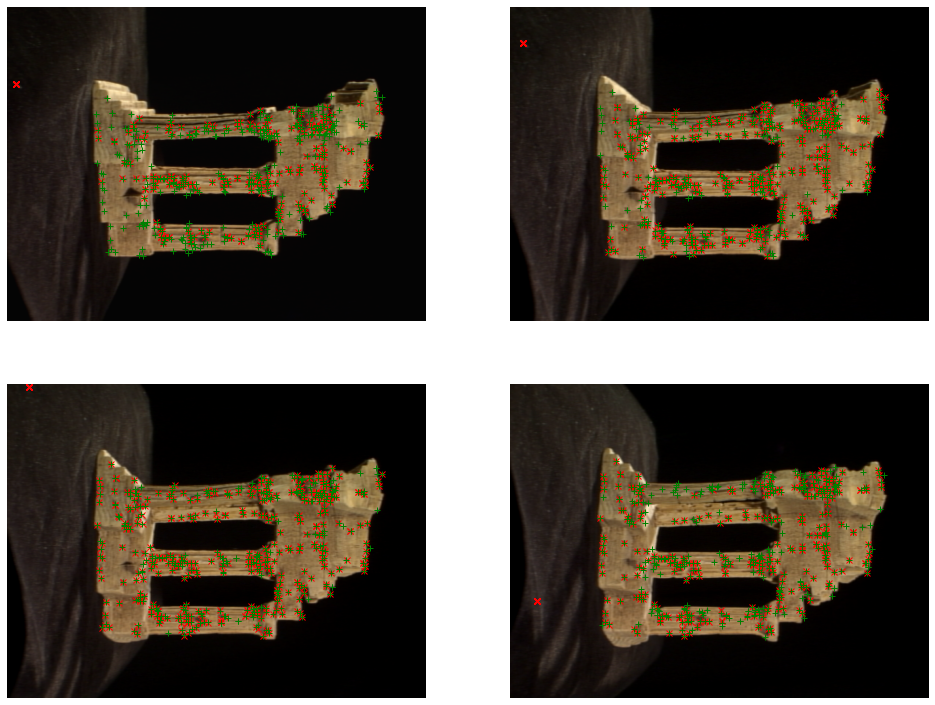

In [24]:
# backproject to all views
img_pt = []
img_pt_shift = backProjection(cams['P'], scene_points_torch[None, ...]).detach().cpu().numpy()
for k in range(i + 1):
    img_pt.append(shift_px_to_center(img_pt_shift[k], w, h))
img_pt = np.stack(img_pt)
plot_landmarks(images[:i + 1], pxs[:, scene_points_inlier], img_pt[:, scene_points_inlier])

fig = plotly_pointcloud_and_camera(pt3D=[{'name': 'Projective PC', 'data': scene_points[scene_points_inlier]}])
fig.show()

### 2. Estimate the Absoluate Dual Quadric $Q_{\infty}^{\ast}$.

#### A review of image of absolute conic (IAC):
The points on $\pi_{\infty}$ may be written as $\mathbf{X}_\infty=(\mathbf{d}^T,0)^T$, and are imaged under a general camera matrix $P=KR[\mathbf{I}|\ -C]$ as
\begin{equation}
	\mathbf{x}=P\mathbf{X}_\infty=KR\mathbf{d}
\end{equation}

So the mapping between $\pi_{\infty}$ and an image is given by the planar homography $\mathbf{x}=H\mathbf{d}$ which independent to camera center $C$
\begin{equation}
	H=KR
\end{equation}
**Image of the absolute conic**: Since the absolute conic $\Omega_\infty$ is on $\pi_{\infty}$, we can compute its image under transform $H$. The IAC $\omega$ is given by
\begin{equation}
	\omega=(KK^T)^{-1}
\end{equation}

**Proof**
\begin{equation}
    \begin{aligned}
        \omega&=H^{-T}\Omega_\infty H^{-1}=(KR)^{-T}\mathbf{I}(KR)^{-1}\\
            &=K^{-T}RR^{-1}K^{-1}\\
            &=(KK^T)^{-1}
    \end{aligned}
\end{equation}

**Dual IAC**. The dual image of the absolute conic is
\begin{equation}
	\omega^\ast=\omega^{-1}=KK^T
\end{equation}

#### The Absolute dual quadric
The absolute dual quadric $Q_{\infty}^{\ast}$ is a degenerate dual (i.e. plane) quadric represented by a 4 × 4 homogeneous matrix of rank 3. Its importance here is that $Q_{\infty}^{\ast}$ encodes both $\Omega_\infty$ and $\pi_{\infty}$ in a very concise fashion, for instance $\pi_{\infty}$  is the null-vector of $Q_{\infty}^{\ast}$ and it has an algebraically simple image projection:
\begin{equation}
    \omega^\ast_i=P_iQ_{\infty}^{\ast}P_i^T
\end{equation}

So the **DIAC** is an image projection of the Absolute dual quadric.

In Euclidean frame $Q_{\infty}^{\ast}$ has the canonical form $\tilde{I}=\begin{bmatrix} I_{3\times 3} &\mathbf{0}_{3\times 1} \\ \mathbf{0}_{1 \times 3} & 0 \end{bmatrix}$. After a projective transformation, in a projective frame that $Q_{\infty}^{\ast}=H\tilde{I}H^T$.

**Appendix**:

- Split the $4 \times 4$ H into submatrices in the form
    $H = \begin{bmatrix}
    A	&b\\
    c	&d
    \end{bmatrix}$.
- For the first camera $P_1=[I \  0]$, after applying $H$ becomes the Euclidean camera matrix	$\widetilde{P_1}=K_1[I\ 0]$. Then we have $K_1[I\ 0]=[I \ 0]
\begin{bmatrix}
    A	&b\\
    c	&d
\end{bmatrix}$, which gives $A=K_1$ and $b=0$. Since H is nonsigular, we can choose $d=1$ and $C=-v^TK_1$. Now we have:
\begin{equation}
    H = \begin{bmatrix}
    K_1			&0\\
    -v^TK_1	&1
    \end{bmatrix}
\end{equation}
- Denote $P_i=[A_i \ a_i]$, we have $\widetilde{P_i}=P_iH=[A_iK_1-a_i v^T K_1 \ a_i]$. Also we constraint the $\widetilde{P_i}=K_i[R_i \ t_i]$, we got $(A_i-a_i v^T)K_1=K_i R_i$.
- Recall the definition $\omega_i=(K_i K_i^T)^{-1}$, we can show that:
        \begin{equation}
            \begin{aligned}
                \omega_i^{\ast} &= K_i R_i R_i^T K_i^T	\\
                           &= (A_i-a_i v^T)\omega_1^{\ast}(A_i-a_i v^T)^T			  \\
                           &=P_i\begin{bmatrix}
                               \omega_1^{\ast}			&-\omega_1^{\ast}v\\
                               -v^T\omega_1^{\ast}	 &v^T\omega_1^{\ast}v
                                           \end{bmatrix} P_i^T \\
                           &\sim P_iQ_{\infty}^{\ast}P_i^T
            \end{aligned}
        \end{equation}

#### Determine a rectifying homography $H$ by auto-calibration constraint.
If we know the camera principle point, as show in above example we move the image coordinate to $(0,0)$ first. We also assume skew zero and have square pixel, so we have following constraints:
\begin{tabular} {l l l c c c}
		$\omega_i(1,1)=\omega_i(2,2)$ 		       &$\Rightarrow$		   &$p_i^1 Q_{\infty}^{\ast} {p_i^1}^T = p_i^2Q{p_i^2}^T$ \\
		$\omega_i(1,2)=0$						   &$\Rightarrow$		   &$p_i^1 Q_{\infty}^{\ast} {p_i^2}^T = 0$ \\
		$\omega_i(1,3)=0$						   &$\Rightarrow$		   &$p_i^1 Q_{\infty}^{\ast} {p_i^3}^T=0$  \\
		$\omega_i(2,3)=0$						   &$\Rightarrow$		   &$p_i^2 Q_{\infty}^{\ast} {p_i^3}^T=0$
\end{tabular}

For concrete Let's define the
\begin{equation}
    P=
    \begin{bmatrix}
        p_{11} &p_{12} &p_{13} &p_{14}\\
        p_{21} &p_{22} &p_{23} &p_{24}\\
        p_{31} &p_{32} &p_{33} &p_{34}\\
        p_{41} &p_{42} &p_{43} &p_{44}
    \end{bmatrix}
    \ \ \ \
    Q_{\infty}^{\ast}=
    \begin{bmatrix}
        q_1 & q_2 &q_3 &q_4\\
        q_2 & q_5 &q_6 &q_7\\
        q_3 & q_6 &q_8 &q_9\\
        q_4 & q_7 &q_9 &q_{10}\\
    \end{bmatrix}
\end{equation}

As the quadric has 10 unknowns, we at least 4 view to solve it.(Notice the first view won't contribute to the equation). Then we have following equation which can be solved by SVD.
\begin{equation}
    A\cdot
    \begin{bmatrix}
        q_1 \\q_2 \\q_3 \\q_4 \\q_5 \\q_6 \\q_7\\ q_8\\ q_9\\ q_{10}
    \end{bmatrix}= \mathbf{0}
\end{equation}

Where
\begin{equation}
\resizebox{1\hsize}{!}{$
	A=
	\begin{bmatrix}
		p_{11}^2-p_{21}^2 &2(p_{11}p_{12}-p_{21}p_{22}) &2(p_{11}p_{13}-p_{21}p_{23}) &2(p_{11}p_{14}-p_{21}p_{24}) &p_{12}^2-p_{22}^2 &2(p_{12}p_{13}-p_{22}p_{23}) &2(p_{12}p_{14}-p_{22}p_{24}) &p_{13}^2-p_{23}^2 &2(p_{13}p_{14}-p_{23}p_{24}) &p_{14}^2-p_{24}^2 \\
		p_{11}p_{21} &p_{11}p_{22}+p_{12}p_{21} &p_{11}p_{23}+p_{13}p_{21} &p_{11}p_{24}+p_{14}p_{21} &p_{12}p_{22} &p_{12}p_{23}+p_{13}p_{22} &p_{12}p_{24}+p_{14}p_{22} &p_{13}p_{23} &p_{13}p_{24}+p_{14}p_{23} &p_{14}p_{24} \\
		p_{11}p_{31} &p_{11}p_{32}+p_{12}p_{31} &p_{11}p_{33}+p_{13}p_{31} &p_{11}p_{34}+p_{14}p_{31} &p_{12}p_{32} &p_{12}p_{33}+p_{13}p_{32} &p_{12}p_{34}+p_{14}p_{32} &p_{13}p_{33} &p_{13}p_{34}+p_{14}p_{33} &p_{14}p_{34} \\
		p_{21}p_{31} &p_{21}p_{32}+p_{22}p_{31} &p_{21}p_{33}+p_{23}p_{31} &p_{21}p_{34}+p_{24}p_{31} &p_{22}p_{32} &p_{22}p_{33}+p_{23}p_{32} &p_{22}p_{34}+p_{24}p_{32} &p_{23}p_{33} &p_{23}p_{34}+p_{24}p_{33} &p_{24}p_{34} \\
		p_{31}^2 &2p_{31}p_{32} &2p_{31}p_{33} &2p_{31}p_{34} &p_{32}^2 &2p_{32}p_{33} &2p_{32}p_{34} &p_{33}^2 &2p_{33}p_{34} &p_{34}^2
	\end{bmatrix}
	$}
\end{equation}

After reconstructing the $Q_{\infty}^{\ast}$, we can decompose the $Q_{\infty}^{\ast}$ to $H\tilde{I}H^T$ by SVD. Where $U,D,V^H=SVD(Q_{\infty}^{\ast})$. Be careful that modern SVD tool will give orthonormal vector components, we need to enforce the constraint that $\hat{D}=diag(1,1,1,0)$. So the H can be construct as following.
\begin{equation}
	H=\begin{bmatrix}
		U_{c1}/\sqrt{D_1} &U_{c2}/\sqrt{D_2} &U_{c3}/\sqrt{D_3} &U_{c4}
	\end{bmatrix}
\end{equation}
Where $U_{ci}$ denote the $i_{th}$ column of matrix U, $D_i$ denote the $i_{th}$ element form diagonal matrix.

So the euclidian reconstruction point cloud and camera matrix can be found as {$P\cdot H$, $H^{-1}\cdot X$}.

In [25]:
Q = PnP.ADQ_f_P(cams['P'])
H = PnP.H_f_ADQ(Q)
rectify_pt = make_homegenous(scene_points_torch) @ torch.linalg.pinv(H).mT
rectify_pt = (rectify_pt[..., :3] / rectify_pt[..., 3:]).detach().cpu().numpy()

fig = plotly_pointcloud_and_camera(pt3D=[{'name': 'Metric PC', 'data': rectify_pt[scene_points_inlier]}])
fig.show()

### 3. Extract camera intrinsic from Absolute Dual Quadric.
As we've seen that:
\begin{equation}
    \omega^\ast_i=P_iQ_{\infty}^{\ast}P_i^T
\end{equation}
As we compute intrinsic directly might suffer numerical error. We take the rectified projection matrix instead.
\begin{equation}
    \omega^\ast_i=P_iQ_{\infty}^{\ast}P_i^T=(P_i H) \tilde{I} (P_i H)^T
\end{equation}

In [26]:
P = cams['P'] @ H[None]

omegas = P @ torch.diag(torch.tensor([1, 1, 1, 0], dtype=torch.float32)) @ P.mT
omegas = omegas / omegas[:, -1, -1][..., None, None]
K = torch.linalg.cholesky(omegas).mT
K_new = torch.zeros_like(K)
for i, KK in enumerate(K):
    K_new[i] = KK / KK[-1, -1]
print(K_new)

[R, t, s] = PnP.Rts_f_P_K(P, K_new)

tensor([[[ 2.1083e+03, -3.0343e+00,  2.8027e-03],
         [ 0.0000e+00,  2.1111e+03,  5.7656e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 2.1447e+03,  4.4001e-03, -5.3615e-04],
         [ 0.0000e+00,  2.1447e+03,  1.9015e-03],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 2.1513e+03,  5.6450e+00, -3.5651e-03],
         [ 0.0000e+00,  2.1552e+03, -3.1880e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 2.0425e+03, -2.2365e-01,  1.2573e-03],
         [ 0.0000e+00,  2.0424e+03, -1.1483e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])


### 4. Display camera pos and point cloud together.

Once we got intrinsic camera parameters, then we can reconstruct the rotation and translation of the camera. Notice there is a sign ambiguity between 3D points and cameras. While $(P, X)$ and $(-P, -X)$ are both valid in algebra. Check which points are front of the cameras.

In [27]:
Rt = torch.cat([R, t[..., None]], dim=-1)
pt3D = torch.from_numpy(rectify_pt).to(device)

combination = [(Rt, pt3D),
               # (-Rt, pt3D),
               # (Rt, -pt3D),
               (-Rt, -pt3D)]

# check the which one is correct combination
numNegatives = []
for comb in combination:
    Rt_sel = comb[0]
    pt = comb[1]
    pt_view = (make_homegenous(pt)[None, ...] @ Rt_sel.mT)

    neg = torch.sum(pt_view[..., -1] < 0)
    numNegatives.append(neg)

numNegatives = torch.tensor(numNegatives)
idx = torch.argmin(numNegatives, dim=0)

comb_sel = combination[idx]

# extract the right combination of camera and 3D point cloud and display them
Rt = comb_sel[0]
pt3D = comb_sel[1]

cameras = PerspectiveCamera(intrinsic=K_new,
                            rotation=Rt[..., :3],
                            translation=Rt[..., 3],
                            scale=s)

fig = plotly_pointcloud_and_camera(pt3D=[{'name': 'Metric point cloud', 'data': pt3D[scene_points_inlier]}],
                                   cameras=[{'name': 'Metric Cameras', 'data': cameras.M.detach().cpu().numpy()}],
                                   cam_scale=500)

# make the plot metric a little
fig.update_layout(scene=dict(
    aspectmode='manual',
    aspectratio=dict(x=2, y=1, z=0.95)
))
fig.show()

**At end**
You might see the camera get noisy when you are adding more views. To make it more stable, you can try following technics:
- Use bundle adjustment. (Which has been implemented for struct from motion already.)
- Constraint the camera intrinsic if the $K$ is the same across all views.